Imports

In [3]:
#############
###paths#####
#############
import sys
import os

from importlib_metadata import distribution
pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
modellingephemeral = '/rds/general/ephemeral/user/mo2016/ephemeral/Documents/modelling'

sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_plot import plot1D, surfpattern
from numerical.countPeaksAnalysisFunctions import countPeaks, varPeakDistFunction
from numerical.generalFunctions import round_it
from numerical.fourierAnalysisFunctions import psEntropyFunction, plotFourier


from analytical.linear_stability_analysis import detailed_turing_analysis_dict
from randomfunctions import plot_all_dispersion, plot_highest_dispersion

from scipy.signal import find_peaks
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



System definitions

In [6]:
circuit_n='turinghill'
variant= 0
n_species=2
mechanism='nogrowth'
L=50; dx =1; J = int(L/dx)
T =500; dt = 0.005; N = int(T/dt)
boundaryCoeff=2;rate=0.1

L=100; dx =1; J = int(L/dx)
T =3000; dt = 0.005; N = int(T/dt)
boundaryCoeff=2;rate=0.1

filename= lambda mechanism, parID: 'circuit%s_variant%s_bc%s_%s_rate%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,boundaryCoeff, mechanism,rate,parID,L,J,T,N)
# filename= lambda mechanism, parID: '%s_variant%s_%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant, mechanism,parID,L,J,T,N)
n_param_sets=2000000
lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# single_lsa_df =  lsa_df.xs(0, level=1)
parID_list = pickle.load(open( modellingephemeral + '/growth/out/numerical/%s/%s/simulation/parID_list_%s.pkl'%(circuit_n,mechanism,filename(mechanism,'x')), "rb" ) )
# parID_list = [int(parID) for parID in parID_list]
instability_df= pickle.load( open(modellingpath + '/growth/out/analytical/instability/instability_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
# singleSsInstability_df = instability_df.loc[instability_df['ss_n']==1]
# singleSsInstability_df
# pattern_df = pickle.load(open( modellingpath + '/growth/out/patternAnalysis/%s/%s/pattern/pattern_df_%s.pkl'%(circuit_n,mechanism,filename(mechanism,'x')), 'rb'))



In [7]:
df1 = instability_df.loc[(instability_df['system_class']=='turing I oscillatory') ]
# print(df1['pattern'].value_counts())

# df1 = instability_df.loc[(instability_df['system_class']=='turing I hopf') ]
print(instability_df['system_class'].value_counts())

hopf                    61890
turing I hopf            1047
turing I oscillatory       29
turing I                    2
Name: system_class, dtype: int64


Functions

In [8]:
def parID_display(parIDss, L,J,T,round=False,crop=100,ss_n=0,df = df1):
    #data
    U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    plot1D(U_final,round=round)

    plt.subplots(figsize=(15,4))

    #dispersion
    plt.subplot(131)
    parID_dispersion(parIDss,crop)

    #convergence
    plt.subplot(132)
    parID_surfpattern(parIDss,L,J,T,morphogen=0)
    plt.tight_layout()
    plt.subplot(133)
    parID_surfpattern(parIDss,L,J,T,morphogen=1)
    plt.tight_layout()

    plt.show()
def parID_surfpattern(parIDss,L,J,T,morphogen=0,record_every_x_hours = 10):
    #data 
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    
    #grids
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 

    #plot
    surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=morphogen, rate=0, savefig=False,filename='',logResults=False,normalize=False)


def parID_dispersion(parIDss,crop, df = df1):
    #dispersion
    parID,ss = [int(x) for x in parIDss.split('.')]
    par_dict = df.loc[(parID,ss)].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    
    # par_dict = df.loc[parIDss].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    out = detailed_turing_analysis_dict(par_dict, circuit_n, n_species)
    plot_highest_dispersion(out[-3][0],crop=crop)


In [9]:
def countPeaks(U, showPlot1D=True):
    peaks = [0,0]
    peaks[0], _ = find_peaks(U[0], prominence=0.1)
    peaks[1], _ = find_peaks(U[1], prominence=0.1)
    if showPlot1D == True:
        plot1D(U,plotPeaks=True, peaks=peaks)

    return peaks

In [10]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)+1e-8)

In [16]:
def patternClassification(U_final, U_record, normalize=True):
    #check if flat
    relRangeFlat = [(np.amax(U) - np.amin(U))/(np.amax(U)+1e-8) for U in U_final]
    if any(i<0.001 for i in relRangeFlat):
        flat=True
    else:
        flat=False

    #check if converged
    relRangeConverged=[0,0]
    for count,Ux_record in enumerate(U_record):
        relRangeConverged[count] = [(np.amax(x) - np.amin(x))/(np.amax(x)+1e-8) for x in np.transpose(Ux_record[-10:])]
    if np.amax(relRangeConverged[0])>0.001 or np.amax(relRangeConverged[1])>0.001:
        converged=False
    else:
        converged=True

    #check if regular
    U_final_norm = [NormalizeData(U) for U in U_final]
    peaks = countPeaks(U_final_norm, showPlot1D=True)

    #calculate distance between peaks in peak0
    std=[0,0]
    for count,singleUpeak in enumerate(peaks):
        if len(singleUpeak)>2:
            peak_dist = [np.linalg.norm(singleUpeak[i]-singleUpeak[i+1]) for i in range(len(singleUpeak)-1)]
            peak_dist = peak_dist/np.sum(peak_dist)
            std[count] = np.std(peak_dist)
        else:
            std[count] = 1
    print(f'std = {std}')
    if std[0]<0.01 and std[1]<0.01:
        regular=True
    else:
        regular=False
        


    if flat==True and converged==True:
        pattern='Homogeneous'
    if flat==True and converged==False:
        pattern='Temporal Oscillator'
    if flat==False and converged==True and regular==True:
        pattern = 'Stationary regular pattern'
    if flat==False and converged==True and regular==False:
        pattern = 'Stationary irregular pattern'

    if flat==False and converged==False and regular==True:
        pattern = 'Non-Stationary regular pattern'
    if flat==False and converged==False and regular==False:
        pattern = 'Non-Stationary irregular pattern'
    # if var[0]>0.1 and var[1]>0.1:





    return pattern, converged, flat, regular



1593460.0


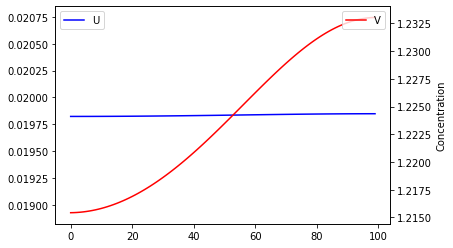

<ipython-input-8-7f07bc2b87a1>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


KeyError: 1593460

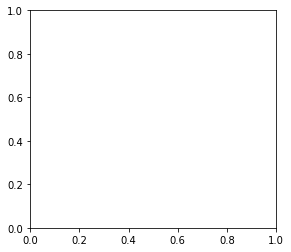

In [12]:
for parIDss in parID_list[20:100]:
    print(parIDss)
    U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
    parID_display(parIDss,L,J,T, crop=50)
    # plot1D(U_final,round=False)
    U_final = np.round(U_final,decimals=4)
    U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    
    pattern, converged, flat, regular = patternClassification(U_final, U_record)
 
    print(f'Pattern = {pattern}')
    print(f'Converged = {converged}, Flat = {flat}, Regular = {regular}')
    print('-----------------------------------')


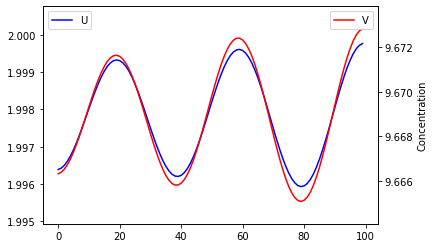

<ipython-input-8-7f07bc2b87a1>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


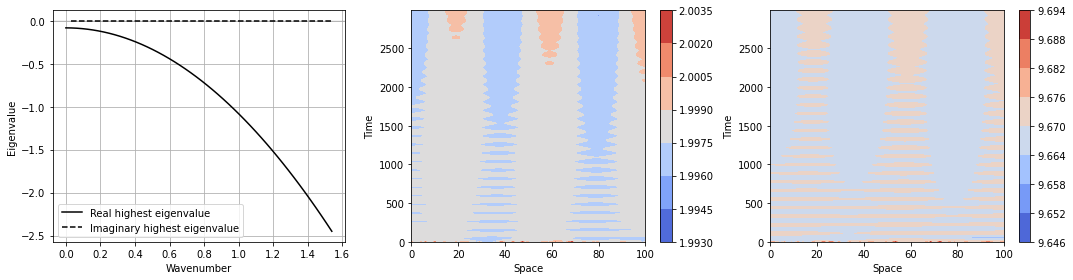

130517.2


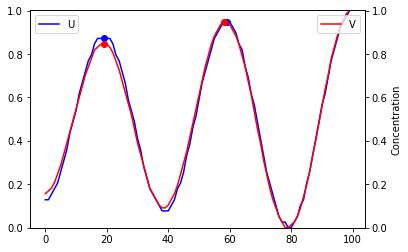

std = [1, 1]
Pattern = Homogeneous
Converged = True, Flat = True, Regular = False
-----------------------------------


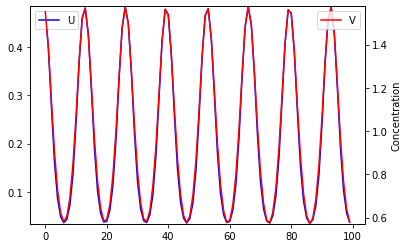

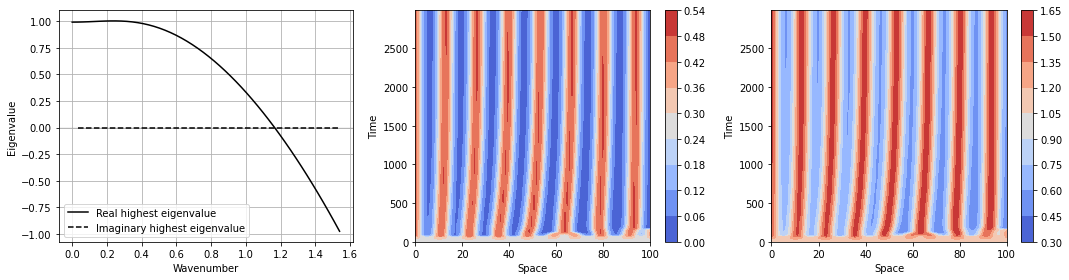

135128.1


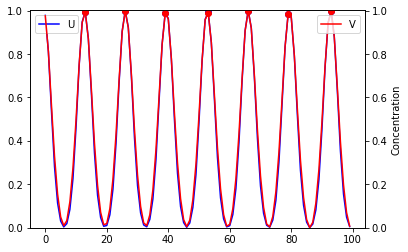

std = [0.005892556509887888, 0.005892556509887888]
Pattern = Non-Stationary regular pattern
Converged = False, Flat = False, Regular = True
-----------------------------------


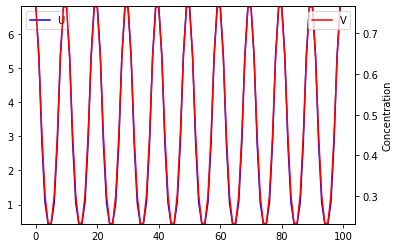

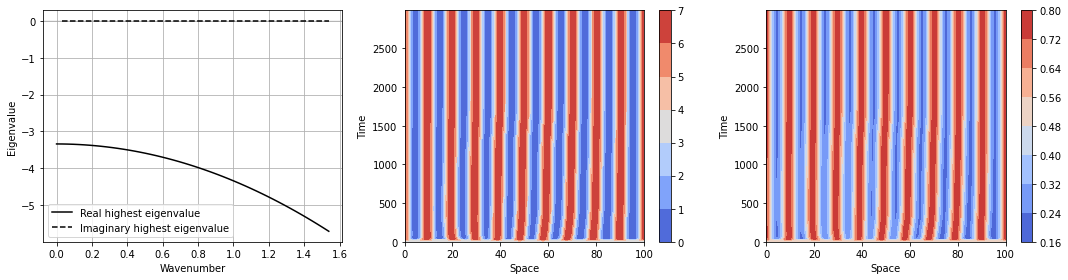

472883.2


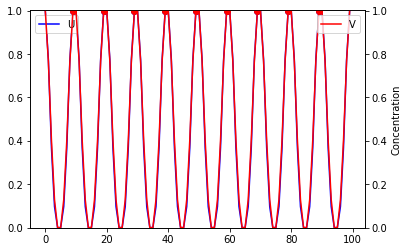

std = [0.0, 0.0]
Pattern = Stationary regular pattern
Converged = True, Flat = False, Regular = True
-----------------------------------


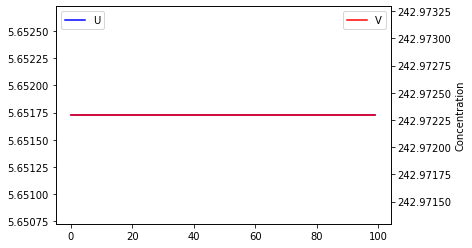

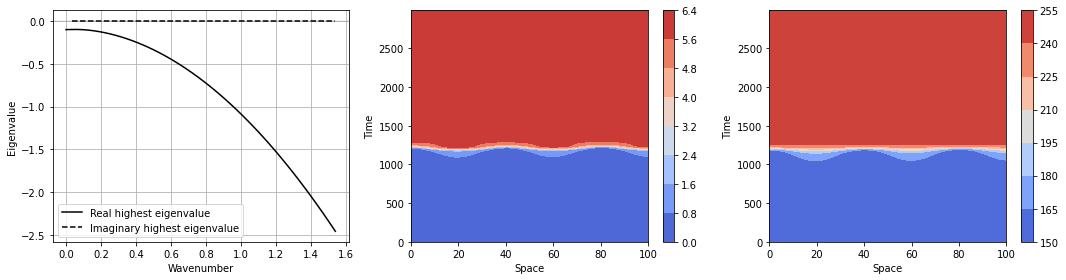

546109.1


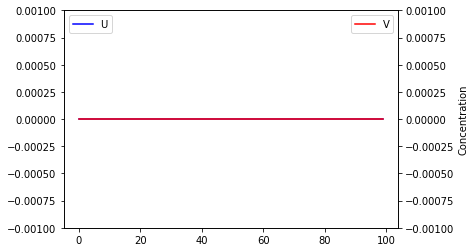

std = [1, 1]
Pattern = Homogeneous
Converged = True, Flat = True, Regular = False
-----------------------------------


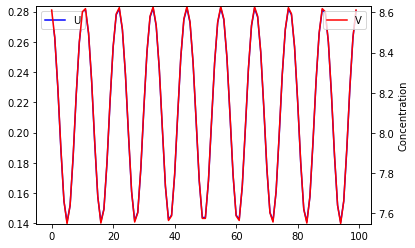

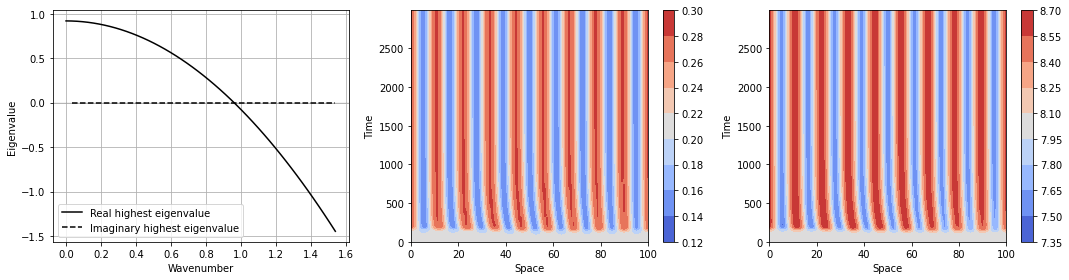

1133916.0


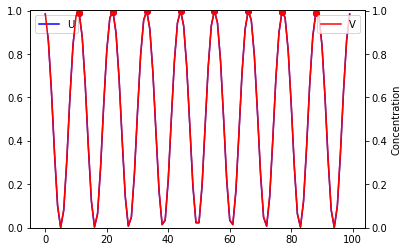

std = [2.7755575615628914e-17, 2.7755575615628914e-17]
Pattern = Stationary regular pattern
Converged = True, Flat = False, Regular = True
-----------------------------------


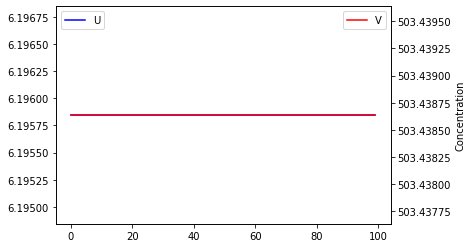

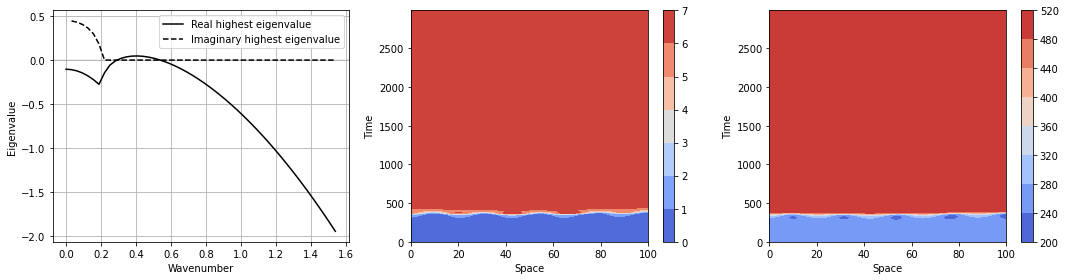

1251569.4


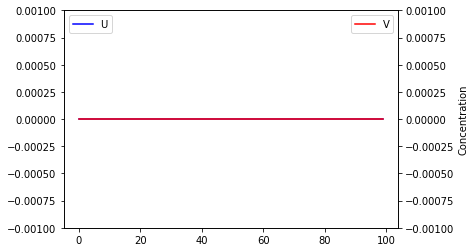

std = [1, 1]
Pattern = Homogeneous
Converged = True, Flat = True, Regular = False
-----------------------------------


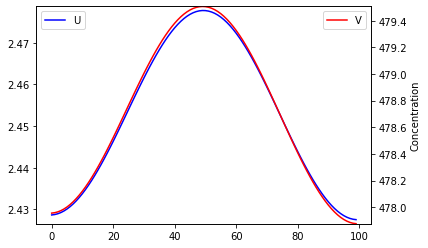

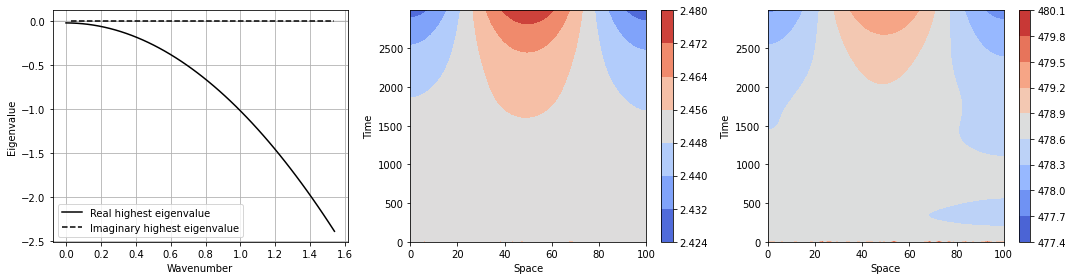

1511110.2


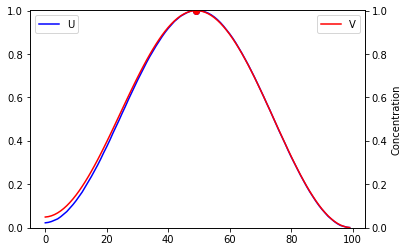

std = [1, 1]
Pattern = Non-Stationary irregular pattern
Converged = False, Flat = False, Regular = False
-----------------------------------


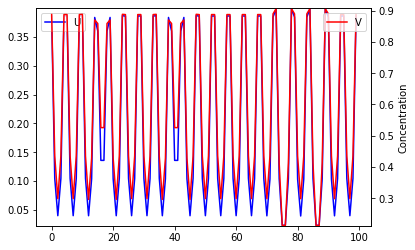

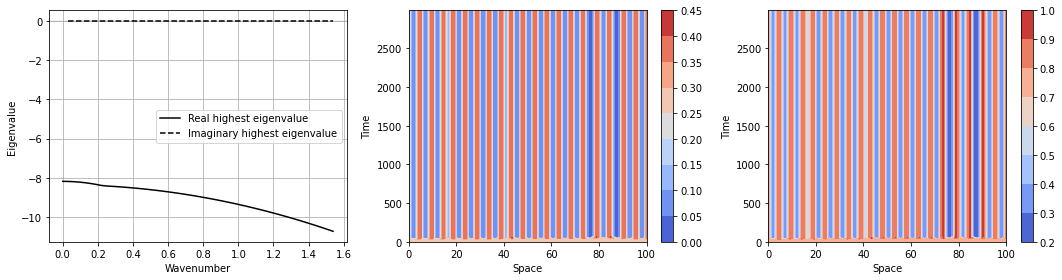

1591223.2


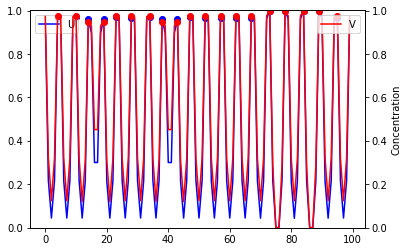

std = [0.0077463843348287665, 0.0077463843348287665]
Pattern = Stationary regular pattern
Converged = True, Flat = False, Regular = True
-----------------------------------


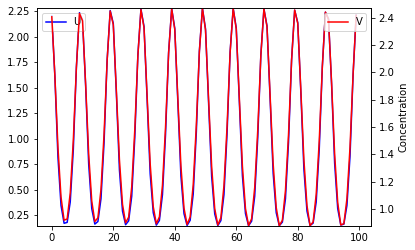

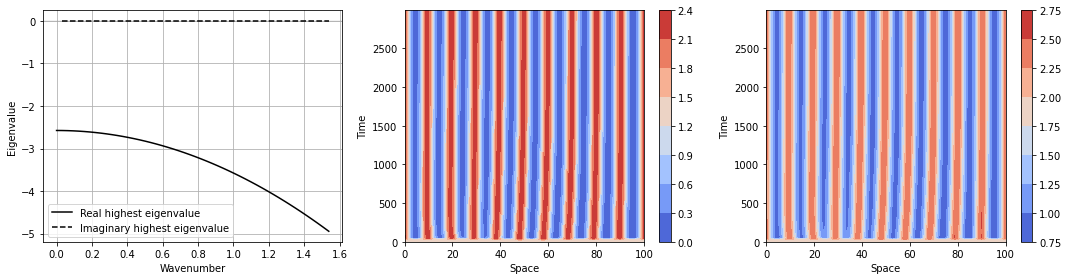

1808247.2


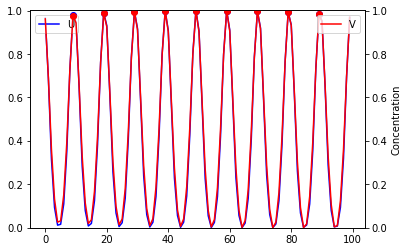

std = [0.0, 0.0]
Pattern = Non-Stationary regular pattern
Converged = False, Flat = False, Regular = True
-----------------------------------


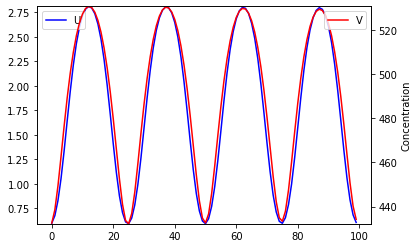

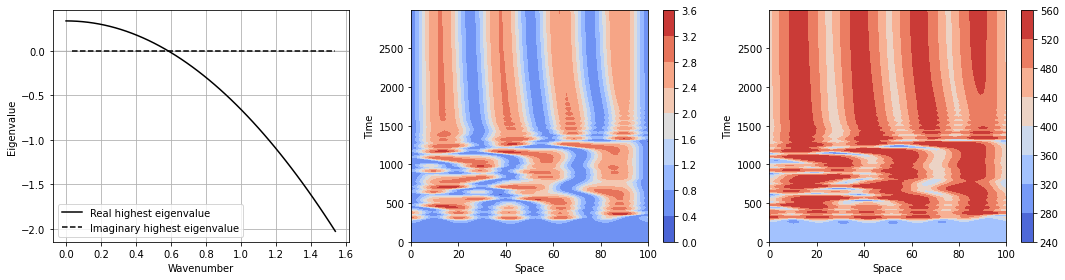

1809921.2


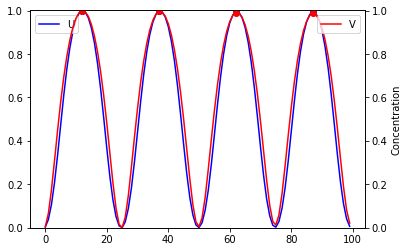

std = [0.0, 0.0]
Pattern = Non-Stationary regular pattern
Converged = False, Flat = False, Regular = True
-----------------------------------


In [17]:
for parIDindex in df1.index:
    try:
        parIDss = f'{parIDindex[0]}.{parIDindex[1]}'
        U_final = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))
        parID_display(parIDss,L,J,T, crop=50)
        print(parIDss)
        U_final = np.round(U_final,decimals=4)
        U_record = pickle.load( open(modellingephemeral + '/growth/out/numerical/%s/%s/simulation/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(mechanism,parIDss)), 'rb'))    
        pattern, converged, flat, regular = patternClassification(U_final, U_record)
    
        print(f'Pattern = {pattern}')
        print(f'Converged = {converged}, Flat = {flat}, Regular = {regular}')
        print('-----------------------------------')
    except:
        FileNotFoundError
        

In [ ]:
x = np.array([], dtype='int64')
len(x)

In [ ]:

df1=lsa_df.loc[lsa_df['pattern']=='Temporal Oscillator']
for parIDindex in df1.index:
    parIDss = f'{parIDindex[0]}.{parIDindex[1]}'
    parID_surfpattern(parIDss,L,J,T,morphogen=1)
    plt.show()
    plt.close()
    parID_surfpattern(parIDss,L,J,T,morphogen=0)
    plt.show()
    plt.close()
    print('---------')